<a href="https://colab.research.google.com/github/MathBSilva/Projeto-393/blob/main/Projeto01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Verifica se está no ambiente Google Colab
# Caso for True, extrai o arquivo .zip e usa o caminho dos arquivos do Colab
# Caso for False, o código .py, estando no mesmo diretório da pasta 'data', recebe o conteúdo extraído de .zip
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# DEBUG
print(IN_COLAB)

if IN_COLAB:
  from zipfile import ZipFile

  with ZipFile('/content/mpeg7_4classes_aug_x8_work.zip', 'r') as myzip:
    myzip.extractall()

True


---

# **Carregando os Datasets de Treinamento e Teste**

---


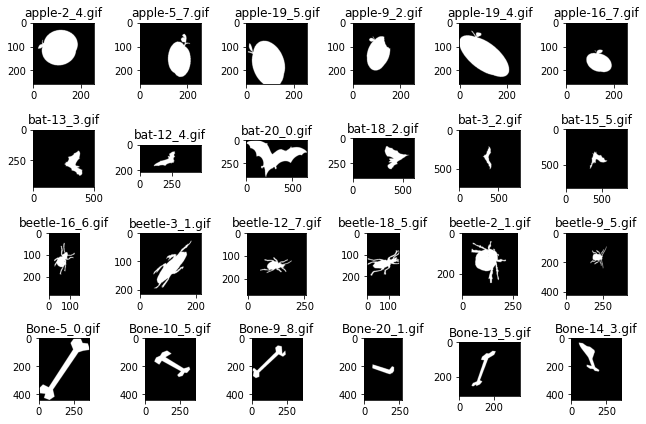

In [2]:
import os

import numpy as np
from skimage import util, transform, filters, color, measure, morphology, io
from sklearn import model_selection, neighbors, metrics, preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

np.random.seed(393)

# 4 classes - Conjunto de Treinamento
if IN_COLAB:
  ds_path = '/content/mpeg7_4classes_aug_x8_work/Train'
else:
  ds_path = 'data/mpeg7_4classes_aug_x8_work/Train'

# Lista das pastas na pasta 'ds_path' (classes)
classes_list = sorted(os.listdir(ds_path))

# Lista com as imagens no dataset
image_list = []
# Lista com os rótulos das imagens
label_list = []

# Lista com os nomes das imagens
filename_list_ = []

# Percorre as classes do dataset
for classe in classes_list:
    
    # Listagem de todas as imagens na pasta daquela classe
    filename_list = os.listdir(os.path.join(ds_path, classe))
    
    # Percorre os arquivos na pasta atual
    for filename in filename_list:
        # Carrega a imagem
        img_temp = io.imread(os.path.join(ds_path, classe, filename), as_gray=True)
        
        # Adiciona a imagem a lista de imagens
        image_list.append(img_temp)
        
        # Adiciona o rótulo da imagem à lista de rótulos
        label_list.append(classe)
        
        # Adiciona o nome da imagem à uma lista (para fins de visualização)
        filename_list_.append(filename)

# Indices das classes dos objetos do dataset
_, _, label_list_idx = np.unique(label_list, return_index=True, return_inverse=True)

# Seleciona apenas as primeiras N imagens de cada classe
image_list_temp = []
filename_list_temp = []

# Itera pelo número de classes
for i in range(4):
    # As 6 primeiras ocorrencias em que label é igual a 'i'.
    image_list_temp += [image_list[j] for j in np.where(label_list_idx==i)[0][:6]]
    filename_list_temp += [filename_list_[j] for j in np.where(label_list_idx==i)[0][:6]]
fig, ax  = plt.subplots(4, 6, figsize=(9, 6))

for i, (image, filename) in enumerate(zip(image_list_temp, filename_list_temp)):
    ax[i//6, i%6].imshow(image, cmap='gray')
    ax[i//6, i%6].set_title(str(filename))

fig.tight_layout()
plt.show()

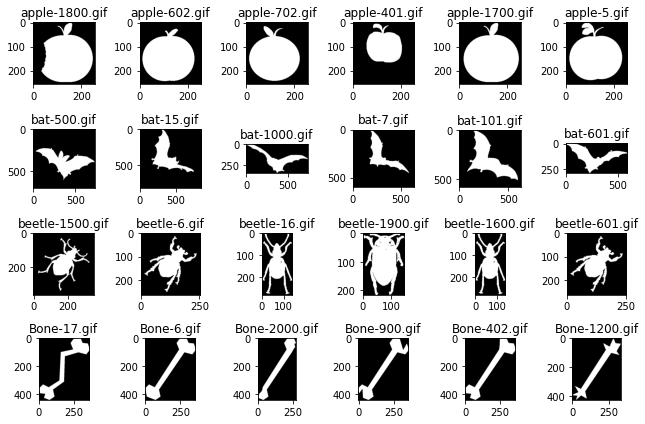

In [3]:
# 4 classes - Conjunto de Teste
if IN_COLAB:
  ds_path_t = '/content/mpeg7_4classes_aug_x8_work/Test'
else:
  ds_path_t = 'data/mpeg7_4classes_aug_x8_work/Test'

# Lista das pastas na pasta 'ds_path_t' (classes)
classes_list = sorted(os.listdir(ds_path_t))

# Lista com as imagens no dataset
image_list_t = []
# Lista com os rótulos das imagens
label_list_t = []

# Lista com os nomes das imagens
filename_list_t_ = []

# Percorre as classes do dataset
for classe in classes_list:
    
    # Listagem de todas as imagens na pasta daquela classe
    filename_list = os.listdir(os.path.join(ds_path_t, classe))
    
    # Percorre os arquivos na pasta atual
    for filename in filename_list:
        # Carrega a imagem
        img_temp = io.imread(os.path.join(ds_path_t, classe, filename), as_gray=True)
        
        # Adiciona a imagem a lista de imagens
        image_list_t.append(img_temp)
        
        # Adiciona o rótulo da imagem à lista de rótulos
        label_list_t.append(classe)
        
        # Adiciona o nome da imagem à uma lista (para fins de visualização)
        filename_list_t_.append(filename)

# Indices das classes dos objetos do dataset
_, _, label_list_test_idx = np.unique(label_list_t, return_index=True, return_inverse=True)

# Seleciona apenas as primeiras N imagens de cada classe
image_list_temp = []
filename_list_temp = []

# Itera pelo número de classes
for i in range(4):
    # As 6 primeiras ocorrencias em que label é igual a 'i'.
    image_list_temp += [image_list_t[j] for j in np.where(label_list_test_idx==i)[0][:6]]
    filename_list_temp += [filename_list_t_[j] for j in np.where(label_list_test_idx==i)[0][:6]]
fig, ax  = plt.subplots(4, 6, figsize=(9, 6))

for i, (image, filename) in enumerate(zip(image_list_temp, filename_list_temp)):
    ax[i//6, i%6].imshow(image, cmap='gray')
    ax[i//6, i%6].set_title(str(filename))

fig.tight_layout()
plt.show()

---

# **Criando lista de características do conjunto de Treinamento**

---



In [4]:
# Nomes das caracteristicas computadas
features = ['area', 'major_axis', 'minor_axis', 'solidity', 'perimeter']
# Arranjo 2D com as caracteristicas das imagens
feature_mat = []

# Lista com as imagens segmentadas (binárias)
seg_list = []

# Lista com os rótulos das imagens
list_label = []

for i, (image, label) in enumerate(zip(image_list, label_list)):
    # DEBUG
    print('Imagem {} - classe {}'.format(i, label))
    
    # Adiciona o rótulos (label) da imagem à lista
    list_label.append(label)

    # Calcula a imagem de rótulos
    im_lbl = measure.label(image)

    # Calcula uma lista de propriedades (caracteristicas) dos objetos na imagem
    """plots = {'Original': image, 'Labels': im_lbl}
    fig, ax = plt.subplots(1, len(plots))
    for n, (title, img) in enumerate(plots.items()):
        cmap = plt.cm.gnuplot if n == len(plots) - 1 else plt.cm.gray
        ax[n].imshow(img, cmap=cmap)
        ax[n].axis('off')
        ax[n].set_title(title)
    plt.show(fig)"""

    props = measure.regionprops(im_lbl)
    
    # Itera pelas propriedades computadas
    for prop in props:
        # Prop. 0: Area
        area = prop.area
       
        # Prop. 1: Maior eixo
        major_axis = prop.major_axis_length
        
        # Prop. 2: Menor eixo
        minor_axis = prop.minor_axis_length 
        
        # Prop. 3: Solidez
        solidity = prop.solidity 
        
        # Prop. 4: Perímetro
        perimeter = prop.perimeter 

        # Monta o vetor de caracteristicas deste objeto.
        feature_list = [area, major_axis, minor_axis, solidity, perimeter]
    
    # Adiciona as caracteristicas desta imagem na matriz de caracteristicas
    feature_mat.append(feature_list)

Imagem 0 - classe apple
Imagem 1 - classe apple
Imagem 2 - classe apple
Imagem 3 - classe apple
Imagem 4 - classe apple
Imagem 5 - classe apple
Imagem 6 - classe apple
Imagem 7 - classe apple
Imagem 8 - classe apple
Imagem 9 - classe apple
Imagem 10 - classe apple
Imagem 11 - classe apple
Imagem 12 - classe apple
Imagem 13 - classe apple
Imagem 14 - classe apple
Imagem 15 - classe apple
Imagem 16 - classe apple
Imagem 17 - classe apple
Imagem 18 - classe apple
Imagem 19 - classe apple
Imagem 20 - classe apple
Imagem 21 - classe apple
Imagem 22 - classe apple
Imagem 23 - classe apple
Imagem 24 - classe apple
Imagem 25 - classe apple
Imagem 26 - classe apple
Imagem 27 - classe apple
Imagem 28 - classe apple
Imagem 29 - classe apple
Imagem 30 - classe apple
Imagem 31 - classe apple
Imagem 32 - classe apple
Imagem 33 - classe apple
Imagem 34 - classe apple
Imagem 35 - classe apple
Imagem 36 - classe apple
Imagem 37 - classe apple
Imagem 38 - classe apple
Imagem 39 - classe apple
Imagem 40 

---
# **Criando lista de características do conjunto de Teste**

---



In [5]:
# Nomes das caracteristicas computadas
features = ['area', 'major_axis', 'minor_axis', 'solidity', 'perimeter']
# Arranjo 2D com as caracteristicas das imagens
feature_mat_t = []

# Lista com as imagens segmentadas (binárias)
seg_list = []

# Lista com os rótulos das imagens
list_label = []

for i, (image, label) in enumerate(zip(image_list_t, label_list_t)):
    # DEBUG
    print('Imagem {} - classe {}'.format(i, label))
    
    # Adiciona o rótulos (label) da imagem à lista
    list_label.append(label)

    # Calcula a imagem de rótulos
    im_lbl = measure.label(image)

    # Opcional: Plota a imagem original e sua imagem de rótulos
    """plots = {'Original': image, 'Labels': im_lbl}
    fig, ax = plt.subplots(1, len(plots))
    for n, (title, img) in enumerate(plots.items()):
        cmap = plt.cm.gnuplot if n == len(plots) - 1 else plt.cm.gray
        ax[n].imshow(img, cmap=cmap)
        ax[n].axis('off')
        ax[n].set_title(title)
    plt.show(fig)"""
    
    # Calcula uma lista de propriedades (caracteristicas) dos objetos na imagem

    props = measure.regionprops(im_lbl)
    
    # Itera pelas propriedades computadas
    for prop in props:
        # Prop. 0: Area
        area = prop.area
       
        # Prop. 1: Maior eixo
        major_axis = prop.major_axis_length
        
        # Prop. 2: Menor eixo
        minor_axis = prop.minor_axis_length 
        
        # Prop. 3: Solidez
        solidity = prop.solidity 
        
        # Prop. 4: Perímetro
        perimeter = prop.perimeter 

        # Monta o vetor de caracteristicas deste objeto.
        feature_list = [area, major_axis, minor_axis, solidity, perimeter]
    
    # Adiciona as caracteristicas desta imagem na matriz de caracteristicas
    feature_mat_t.append(feature_list)

Imagem 0 - classe apple
Imagem 1 - classe apple
Imagem 2 - classe apple
Imagem 3 - classe apple
Imagem 4 - classe apple
Imagem 5 - classe apple
Imagem 6 - classe apple
Imagem 7 - classe apple
Imagem 8 - classe apple
Imagem 9 - classe apple
Imagem 10 - classe apple
Imagem 11 - classe apple
Imagem 12 - classe apple
Imagem 13 - classe apple
Imagem 14 - classe apple
Imagem 15 - classe apple
Imagem 16 - classe apple
Imagem 17 - classe apple
Imagem 18 - classe apple
Imagem 19 - classe apple
Imagem 20 - classe apple
Imagem 21 - classe apple
Imagem 22 - classe apple
Imagem 23 - classe apple
Imagem 24 - classe apple
Imagem 25 - classe apple
Imagem 26 - classe apple
Imagem 27 - classe apple
Imagem 28 - classe apple
Imagem 29 - classe apple
Imagem 30 - classe apple
Imagem 31 - classe apple
Imagem 32 - classe apple
Imagem 33 - classe apple
Imagem 34 - classe apple
Imagem 35 - classe apple
Imagem 36 - classe apple
Imagem 37 - classe apple
Imagem 38 - classe apple
Imagem 39 - classe apple
Imagem 40 

---
# **Converte as listas de características em arrays NumPy**

---



In [6]:
# Converte a lista de caracteristicas de Treinamento para um arranjo NumPy
feature_map = np.array(feature_mat)

In [7]:
# Converte a lista de caracteristicas de Teste para um arranjo NumPy
feature_map_test = np.array(feature_mat_t)

In [8]:
df = pd.DataFrame(feature_map, columns=features)

df['class'] = label_list

print('\033[1m' + '\n-----  Características do conjunto de Treinamento  -----\n' + '\033[0m' )
display(df)


-----  Características do conjunto de Treinamento  -----



,area,major_axis,minor_axis,solidity,perimeter,class
0,17849.0,158.436264,144.147022,0.965907,582.026479,apple
1,11419.0,161.592902,94.414920,0.893855,583.712770,apple
2,20453.0,194.803072,135.474236,0.935422,698.097546,apple
3,10160.0,143.104002,92.554550,0.909987,489.759451,apple
4,22564.0,248.735082,116.852131,0.936810,781.832611,apple
...,...,...,...,...,...,...
499,11568.0,310.053741,82.972093,0.508372,812.021428,bone
500,36863.0,603.453560,119.698667,0.595602,1340.030663,bone
501,3682.0,263.814560,42.901729,0.425911,565.564538,bone
502,6193.0,340.686414,32.781534,0.581502,705.648845,bone


In [9]:
df_test = pd.DataFrame(feature_map_test, columns=features)

df_test['class_test'] = label_list_t

print('\033[1m' + '\n----------  Características do conjunto de Teste  ----------\n' + '\033[0m' )
display(df_test)


----------  Características do conjunto de Teste  ----------



,area,major_axis,minor_axis,solidity,perimeter,class_test
0,34893.0,223.804589,206.136010,0.884218,899.364574,apple
1,33380.0,215.439708,199.504771,0.951106,787.050865,apple
2,31706.0,207.302064,200.160814,0.896688,846.027525,apple
3,16702.0,158.800849,140.396894,0.889161,668.771645,apple
4,37498.0,226.518978,216.785362,0.914675,897.435642,apple
...,...,...,...,...,...,...
211,37803.0,621.575230,120.697614,0.592356,1368.290547,bone
212,21696.0,563.285451,80.368933,0.567275,1179.432683,bone
213,31375.0,642.028431,108.760044,0.506931,1381.444876,bone
214,37803.0,621.575230,120.697614,0.592356,1368.290547,bone


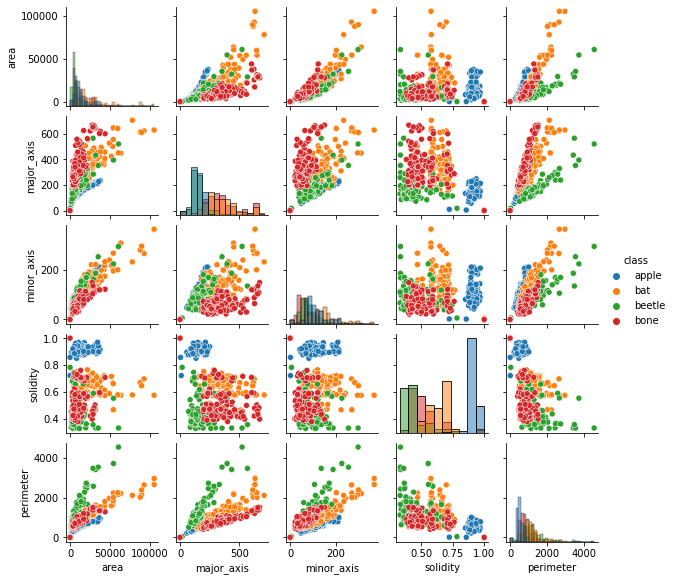

In [10]:
g = sns.PairGrid(df, hue='class', vars=features)
g.fig.set_size_inches(8, 8)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

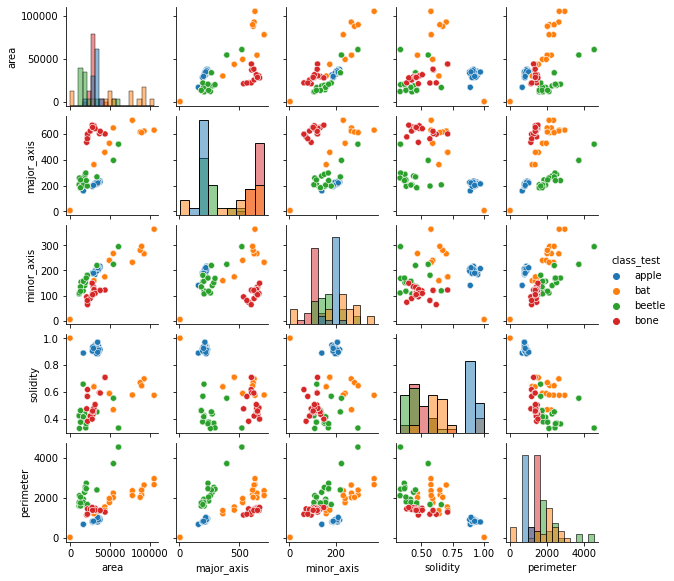

In [11]:
g = sns.PairGrid(df_test, hue='class_test', vars=features)
g.fig.set_size_inches(8, 8)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

In [12]:
with np.printoptions(precision=4, suppress=True):
    # Média das caracteristicas do conjunto de Treinamento
    print('Média:')
    print(feature_map.mean(0))
    # Desvio padrão das caracteroisticas do conjunto de Treinamento
    print('Desvio padrão:')
    print(feature_map.std(0))

Média:
[14926.8214   252.9488   100.2164     0.6344   953.6541]
Desvio padrão:
[15085.2462   150.0867    57.2206     0.2028   562.7993]


In [13]:
with np.printoptions(precision=4, suppress=True):
    # Média das caracteristicas do conjunto de Teste
    print('Média:')
    print(feature_map_test.mean(0))
    # Desvio padrão das caracteristicas do conjunto de Teste
    print('Desvio padrão:')
    print(feature_map_test.std(0))

Média:
[35908.287    400.3939   171.6393     0.6284  1576.9272]
Desvio padrão:
[23075.1611   212.5497    70.5034     0.2098   802.6737]


---

# **Transformada normal de características**

---




In [14]:
# Transformada Normal de Caracteristicas de Treinamento
feature_map_norm = (feature_map - feature_map.mean(0)) / feature_map.std(0)

In [15]:
# Transformada Normal de Caracteristicas de Teste
feature_map_test_norm = (feature_map_test - feature_map_test.mean(0)) / feature_map_test.std(0)

In [16]:
with np.printoptions(precision=4, suppress=True):
    # Média das caracteristicas normalizadas de Treinamento
    print('Média:')
    print(feature_map_norm.mean(0))
    # Desvio padrão das caracteristicas normalizadas de Treinamento
    print('Desvio padrão:')
    print(feature_map_norm.std(0))

Média:
[-0. -0.  0. -0. -0.]
Desvio padrão:
[1. 1. 1. 1. 1.]


In [17]:
with np.printoptions(precision=4, suppress=True):
    # Média das caracteristicas normalizadas de Teste
    print('Média:')
    print(feature_map_test_norm.mean(0))
    # Desvio padrão das caracteristicas normalizadas de Teste
    print('Desvio padrão:')
    print(feature_map_test_norm.std(0))

Média:
[ 0.  0.  0.  0. -0.]
Desvio padrão:
[1. 1. 1. 1. 1.]


In [18]:
df_norm = pd.DataFrame(feature_map_norm, columns=features)

df_norm['class'] = label_list
print('\033[1m' + '\nCaracterísticas normalizadas do conjunto de Treinamento\n' + '\033[0m' )
display(df_norm)


Características normalizadas do conjunto de Treinamento



,area,major_axis,minor_axis,solidity,perimeter,class
0,0.193711,-0.629720,0.767741,1.634257,-0.660320,apple
1,-0.232533,-0.608687,-0.101388,1.279017,-0.657324,apple
2,0.366330,-0.387414,0.616173,1.483954,-0.454081,apple
3,-0.315992,-0.731876,-0.133900,1.358550,-0.824263,apple
4,0.506268,-0.028075,0.290729,1.490797,-0.305298,apple
...,...,...,...,...,...,...
499,-0.222656,0.380479,-0.301365,-0.621539,-0.251657,bone
500,1.454148,2.335348,0.340476,-0.191466,0.686526,bone
501,-0.745418,0.072396,-1.001644,-1.028098,-0.689570,bone
502,-0.578964,0.584579,-1.178506,-0.260982,-0.440664,bone


In [19]:
df_test_norm = pd.DataFrame(feature_map_test_norm, columns=features)

df_test_norm['class_test'] = label_list_t
print('\033[1m' + '\n---  Características normalizadas do conjunto de Teste  ---\n' + '\033[0m' )
display(df_test_norm)


---  Características normalizadas do conjunto de Teste  ---



,area,major_axis,minor_axis,solidity,perimeter,class_test
0,-0.043999,-0.830814,0.489291,1.219671,-0.844132,apple
1,-0.109567,-0.870169,0.395235,1.538547,-0.984057,apple
2,-0.182113,-0.908455,0.404540,1.279122,-0.910581,apple
3,-0.832336,-1.136643,-0.443134,1.243238,-1.131413,apple
4,0.068893,-0.818044,0.640338,1.364869,-0.846535,apple
...,...,...,...,...,...,...
211,0.082110,1.040610,-0.722543,-0.171725,-0.259927,bone
212,-0.615913,0.766369,-1.294553,-0.291296,-0.495213,bone
213,-0.196457,1.136838,-0.891862,-0.578974,-0.243539,bone
214,0.082110,1.040610,-0.722543,-0.171725,-0.259927,bone


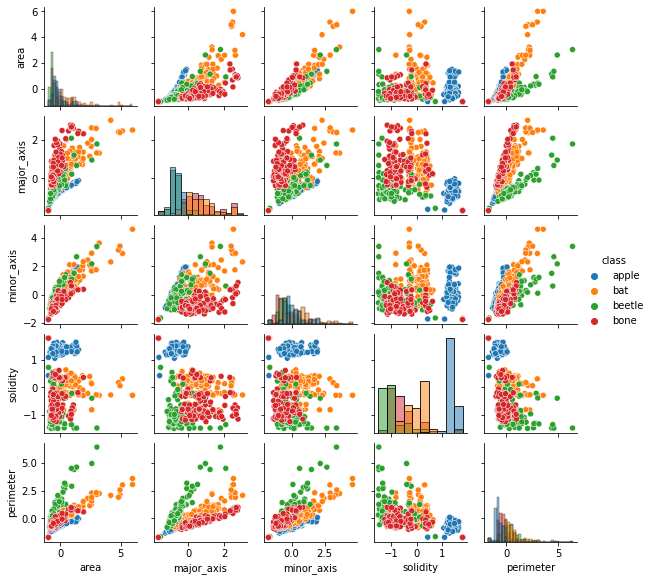

In [20]:
g = sns.PairGrid(df_norm, hue='class', vars=features)
g.fig.set_size_inches(8, 8)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

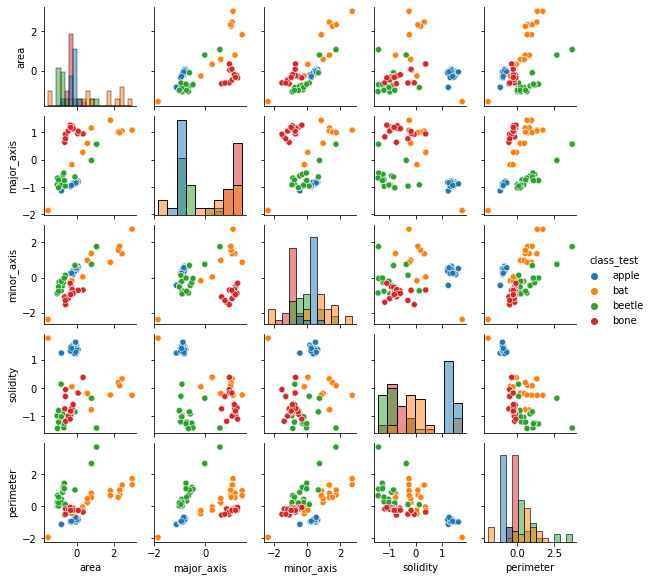

In [21]:
g = sns.PairGrid(df_test_norm, hue='class_test', vars=features)
g.fig.set_size_inches(8, 8)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

---

# **Selecionando características e separando parte do conjunto de treinamento para validação**

---



In [22]:
# Selecionamos apenas duas caracteristicas: Eixo Maior e Perímetro
feature_map_ok = feature_map[:,1:5]
feature_map_test_ok = feature_map_test[:,1:5]

# Separa 25% do conjuto de completo para validação. 75% para treinamento.
X_train, X_val, y_train, y_val = model_selection.train_test_split(feature_map_ok, 
                                                                        label_list, 
                                                                        test_size=0.25, 
                                                                        stratify=label_list,
                                                                        random_state=393)

In [23]:
# Média das caracteristicas do conjunto de treinamento
X_train_mean = X_train.mean(0)

# Desvio padrão das caracteristicas do conjunto de treinamento
X_train_std = X_train.std(0)

scaler = preprocessing.StandardScaler().fit(X_train)

with np.printoptions(precision=4, suppress=True):
    print(f'Média:  \t {np.array(scaler.mean_)}')
    print(f'Desv. pad.: \t {np.array(scaler.scale_)}')

Média:  	 [253.6689 100.092    0.6327 953.5711]
Desv. pad.: 	 [148.373   54.385    0.2009 561.8586]


In [24]:
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
Test_norm = scaler.transform(feature_map_test_ok)

with np.printoptions(precision=4, suppress=True):
    print(f'Treino: \t {X_train_norm.mean():.4f} ± {X_train_norm.std():.4f}')
    print(f'Validação: \t {X_val_norm.mean():.4f} ± {X_val_norm.std():.4f}')
    print(f'Teste:   \t {Test_norm.mean():.4f} ± {Test_norm.std():.4f}')

Treino: 	 0.0000 ± 1.0000
Validação: 	 0.0062 ± 1.0737
Teste:   	 0.8481 ± 1.4077


---

# **Construindo o classificador K-NN e testando usando o conjunto de validação**

---



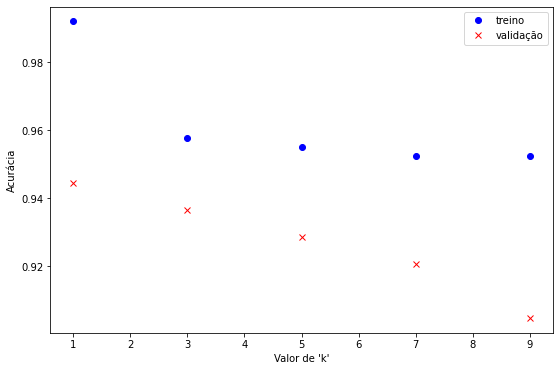

In [25]:
k_list = [1, 3, 5, 7, 9]
# Lista com as acurácias de treino
acc_train_list = []
# Lista com as acurácias de validação
acc_val_list = []

for k_ in k_list:
    # Constrói um classificador K-NN. K = k_
    clf = neighbors.KNeighborsClassifier(n_neighbors=k_)

    # Treinando o classificador
    clf.fit(X_train_norm, y_train)

    # Testando o classificador (usando o conjunto de validação)
    pred = clf.predict(X_val_norm)
    acc_val = metrics.accuracy_score(y_val, pred)
    
    acc_val_list.append(acc_val)
    
    # Testando o classificador (usando o conjunto de treino)
    pred_train = clf.predict(X_train_norm)
    acc_train = metrics.accuracy_score(y_train, pred_train)
    
    acc_train_list.append(acc_train)  
plt.figure(figsize=(9, 6))

plt.plot(k_list, acc_train_list, 'o', color='blue', label='treino')
plt.plot(k_list, acc_val_list, 'x', color='red', label='validação')
plt.xlabel("Valor de 'k'")
plt.ylabel("Acurácia")
plt.legend(loc='best')

plt.show()

In [26]:
# Acertos
acertos = y_val == pred

print('\n Predição:')
print(pred)
print('\nReal:')
print(y_val)
print('\nAcerto/Erro:')
print(acertos.astype(int))


 Predição:
['beetle' 'bat' 'bat' 'apple' 'apple' 'apple' 'beetle' 'beetle' 'apple'
 'bone' 'bat' 'bat' 'apple' 'bat' 'apple' 'apple' 'bat' 'beetle' 'bat'
 'bone' 'bone' 'bat' 'beetle' 'bone' 'beetle' 'bone' 'apple' 'beetle'
 'beetle' 'bone' 'bat' 'apple' 'beetle' 'apple' 'apple' 'apple' 'bone'
 'bat' 'apple' 'beetle' 'beetle' 'bone' 'apple' 'apple' 'bone' 'apple'
 'apple' 'bat' 'bone' 'bat' 'bone' 'beetle' 'beetle' 'beetle' 'beetle'
 'beetle' 'bat' 'bone' 'bone' 'apple' 'bone' 'bat' 'bat' 'bat' 'apple'
 'beetle' 'bat' 'bat' 'bone' 'bat' 'bone' 'beetle' 'apple' 'beetle' 'bone'
 'bone' 'bat' 'beetle' 'bat' 'apple' 'apple' 'bat' 'apple' 'bone' 'beetle'
 'bat' 'apple' 'beetle' 'bat' 'bat' 'bat' 'beetle' 'apple' 'bone' 'beetle'
 'beetle' 'bone' 'beetle' 'bone' 'beetle' 'beetle' 'bone' 'beetle'
 'beetle' 'bone' 'bone' 'beetle' 'bone' 'bone' 'bone' 'bat' 'beetle'
 'beetle' 'bone' 'bone' 'bone' 'apple' 'beetle' 'apple' 'bone' 'beetle'
 'apple' 'apple' 'beetle' 'bone' 'apple']

Real:
['bat', '

In [27]:
print('\033[1m' + '\n--------------- Validação ---------------\n' + '\033[0m' )
print('\033[1m' + '\nMatriz de confusão:' + '\033[0m')
print(metrics.confusion_matrix(y_val, pred))

print('\033[1m' + '\nRelatório de classificação:' + '\033[0m')
print(metrics.classification_report(y_val, pred))


--------------- Validação ---------------


Matriz de confusão:
[[30  0  2  0]
 [ 0 25  2  4]
 [ 0  1 30  0]
 [ 0  1  2 29]]

Relatório de classificação:
              precision    recall  f1-score   support

       apple       1.00      0.94      0.97        32
         bat       0.93      0.81      0.86        31
      beetle       0.83      0.97      0.90        31
        bone       0.88      0.91      0.89        32

    accuracy                           0.90       126
   macro avg       0.91      0.90      0.90       126
weighted avg       0.91      0.90      0.90       126



In [28]:
print('k \t acc. treino \t acc. val')
print('----------------------------')
for k_, acc_t, acc_v in zip(k_list, acc_train_list, acc_val_list):
    print(f'{k_} \t {acc_t:.4f} \t {acc_v:.4f}')

k_best = k_list[np.argmax(acc_val_list)]
print(f'\nMelhor \'k\': {k_best} ({np.max(acc_val_list):.4f} acc.)')

k 	 acc. treino 	 acc. val
----------------------------
1 	 0.9921 	 0.9444
3 	 0.9577 	 0.9365
5 	 0.9550 	 0.9286
7 	 0.9524 	 0.9206
9 	 0.9524 	 0.9048

Melhor 'k': 1 (0.9444 acc.)


---

# **Construindo o classificador K-NN usando o conjunto de teste com o melhor 'k' obtido da validação**

---



In [29]:
# Constrói um classificador K-NN. K = k_best
clf = neighbors.KNeighborsClassifier(n_neighbors=k_best)

# Treinando o classificador
clf.fit(X_train_norm, y_train)

# Testando o classificador (usando o conjunto de TESTES)
pred = clf.predict(Test_norm)
acc_val = metrics.accuracy_score(label_list_t, pred)

In [30]:
# Acertos
acertos = label_list_t == pred

print('\n Predição:')
print(pred)
print('\nReal:')
print(label_list_t)
print('\nAcerto/Erro:')
print(acertos.astype(int))


 Predição:
['apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple'
 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple'
 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple'
 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple'
 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple'
 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple'
 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat'
 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat'
 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat'
 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat'
 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'beetle' 'beetle' 'beetle' 'beetle'
 'beetle' 'beetle' 'beetle' 'beetle' 'beetle' 'beetle' 'beetle' 'beetle'
 'beetle' 'beetle' 'beetle' 'beetle' 'beetle' 'beetle' 'beetle' 'beetle'
 'beetle' 'beetle' 'beetle' 'beetle' 'b

In [31]:
print('\033[1m' + '\n--------------- Teste ---------------\n' + '\033[0m' )

print('\033[1m' + '\nMatriz de confusão:' + '\033[0m')
print(metrics.confusion_matrix(label_list_t, pred))

print('\033[1m' + '\nRelatório de classificação:' + '\033[0m')
print(metrics.classification_report(label_list_t, pred))


--------------- Teste ---------------


Matriz de confusão:
[[54  0  0  0]
 [ 0 54  0  0]
 [ 0  0 54  0]
 [ 0  0  0 54]]

Relatório de classificação:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        54
         bat       1.00      1.00      1.00        54
      beetle       1.00      1.00      1.00        54
        bone       1.00      1.00      1.00        54

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216

